In [35]:
# we load the things!

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import * 
from ngsolve.meshes import MakeStructured2DMesh

import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import psutil

import os
current_dir = os.getcwd()
figures_dir = os.path.join(current_dir, '..', 'figures')
os.makedirs(figures_dir, exist_ok=True)

In [36]:
# some helper functions
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [37]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [38]:
# Functions for plotting, linear regression fit line for convergence

def reference_line_func(h_values, scaling_factor, slope):

    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):

    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [39]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for a tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(a, b, c):
    s = (a + b + c) / 2  
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def circumradius_2D(a, b, c):
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            a = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(a, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

In [40]:
# Hodge Laplace for 1-forms function

def hodgeLaplace1Forms(mesh,
                       u_m = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if u_m is None:
        u_m = CF((0,0))


    H_curl = HCurl(mesh, order=order, type1=False)  # For 1-forms, H(curl) space
    H_1 = H1(mesh, order=order+1)     # For 0-forms, H1 space
    fes = H_curl * H_1
    (u, p), (v, q) = fes.TnT()

    B = BilinearForm(fes)

    B += p * q * dx
    B += - u * grad(q) * dx

    B +=  grad(p) * v * dx
    B +=  curl(u) * curl(v) * dx

    n = specialcf.normal(mesh.dim)
    h = specialcf.mesh_size

    gamma_p_v = CF(v[1]*n[0] - v[0]*n[1])
    gamma_p_u = CF(u[1]*n[0] - u[0]*n[1])

    gamma_n_u = CF(Grad(u)[1,0] - Grad(u)[0,1])
    gamma_n_v = CF(Grad(v)[1,0] - Grad(v)[0,1])

    B += - gamma_n_u * gamma_p_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    B += - gamma_p_u * gamma_n_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    B += (C_w / h) * gamma_p_u  * gamma_p_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))

    f = CF(GCurl(GCurl(u_m)) - GGrad(GDiv(u_m)))

    rhs = LinearForm(fes)
    rhs += f * v * dx

    gamma_p_u_m = CF((-n[1]*u_m[0] + n[0]*u_m[1]))
    
    rhs += (C_w / h) * gamma_p_u_m * gamma_p_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    rhs += - gamma_p_u_m * gamma_n_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    rhs +=  - u_m * n * q * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    with TaskManager():
        B.Assemble()
        rhs.Assemble()

    sol = GridFunction(fes)
    res = rhs.vec-B.mat * sol.vec
    inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    sol.vec.data += inv * res

    gf_u , gf_p = sol.components

    curl_u = CF(Grad(gf_u)[1,0] - Grad(gf_u)[0,1])
    grad_p = grad(gf_p)

    #curl_u_m = CF(GCurl(u_m))
    curl_u_m = CF(GCurl(u_m))
    p_m = - CF(GDiv(u_m))
    grad_p_m = CF(GGrad(p_m))

    L2_error_u = sqrt(Integrate((gf_u - u_m)**2, mesh))
    L2_error_curl_u = sqrt(Integrate((curl_u - curl_u_m)**2, mesh))
    L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
    L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

    gf_gamma_p_u = CF(gf_u[1]*n[0] - gf_u[0]*n[1])
    gf_gamma_p_u_m = CF(u_m[1]*n[0] - u_m[0]*n[1])

    gf_gamma_n_u = curl_u
    gf_gamma_n_u_m = curl_u_m
    gf_u_n = CF(gf_u * n)
    gf_u_n_m = CF(u_m * n)

    L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_u_n = sqrt(Integrate((gf_u_n - gf_u_n_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_p_Gamma = sqrt(Integrate((gf_p - p_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))

    # terms for the hashtag error!
    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

    HT_error_gamma_p = sqrt(1/h_avg * Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    HT_error_gamma_n = sqrt(h_avg * Integrate((gf_gamma_n_u - gf_gamma_n_u_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    #HT_error_u = L2_error_u + L2_error_curl_u + HT_error_gamma_p + HT_error_gamma_n
    HT_error_u = HT_error_gamma_n

    return fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u

In [41]:
# definition of manufactured solutions

#omega_m_sinusoids_2D = CF((-sin(pi*x)*cos(pi*y), cos(pi*x)*sin(pi*y))) # This one vanishes!
#omega_m_sinusoids_2D = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y))) # This one vanishes!
omega_m_sinusoids_2D = CF((-cos(x)*sin(y), sin(x)*cos(y))) # This is a manufactured solution that DOESNT vanish on the boundary!


# A = 0.05  # Pulse Amplitude
# sigma_pulse = 0.05  # Pulse Width
# r0 = (0.5, 0.5)  # Pulse Center
# n_pulse = (1, 0)  # Pulse Direction

# omega_m_gauss_2D = CF((
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[0],
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[1]
# ))


In [42]:
# Convergence study data generation for 2D

refinementVals = [30, 35, 40] # elements per direction

maxh_values = [] 

Cw_vals = logspace_custom_decades(1, 10**3, 4)

orders = [1, 2, 3, 4]

results_cw_2D = []

for refinement_step in refinementVals: 
    #print(f"hmax after refinement {refinement_step}: {h_max_eval}")
    mesh = MakeStructured2DMesh(quads=False, nx=refinement_step, ny=refinement_step)
    h_max_eval = calc_hmax(mesh)
    maxh_values.append(h_max_eval)
    print("doing h_max: ", h_max_eval)

    for order_cw in orders:
        results_cw = []
        print("doing order: ", order_cw)

        for C_w in Cw_vals:
            u_m = omega_m_sinusoids_2D

            ndof, res, L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u = hodgeLaplace1Forms(
                mesh, u_m=u_m, order=order_cw, C_w=C_w
            )

            results_cw.append({
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_u': L2_error_u,
                'L2_error_curl_u': L2_error_curl_u,
                'L2_error_p': L2_error_p,
                'L2_error_grad_p': L2_error_grad_p,
                'L2_error_gamma_p_u': L2_error_gamma_p_u,
                'L2_error_u_n': L2_error_u_n,
                'L2_error_p_Gamma': L2_error_p_Gamma,
                'HT_error_u': HT_error_u
            })

        df_cw = pd.DataFrame(results_cw)
        results_cw_2D.append(df_cw)

doing h_max:  0.023570226039551667
doing order:  1
doing order:  2
doing order:  3
doing order:  4
doing h_max:  0.020203050891044228
doing order:  1
doing order:  2
doing order:  3
doing order:  4
doing h_max:  0.017677669529663702
doing order:  1
doing order:  2
doing order:  3
doing order:  4


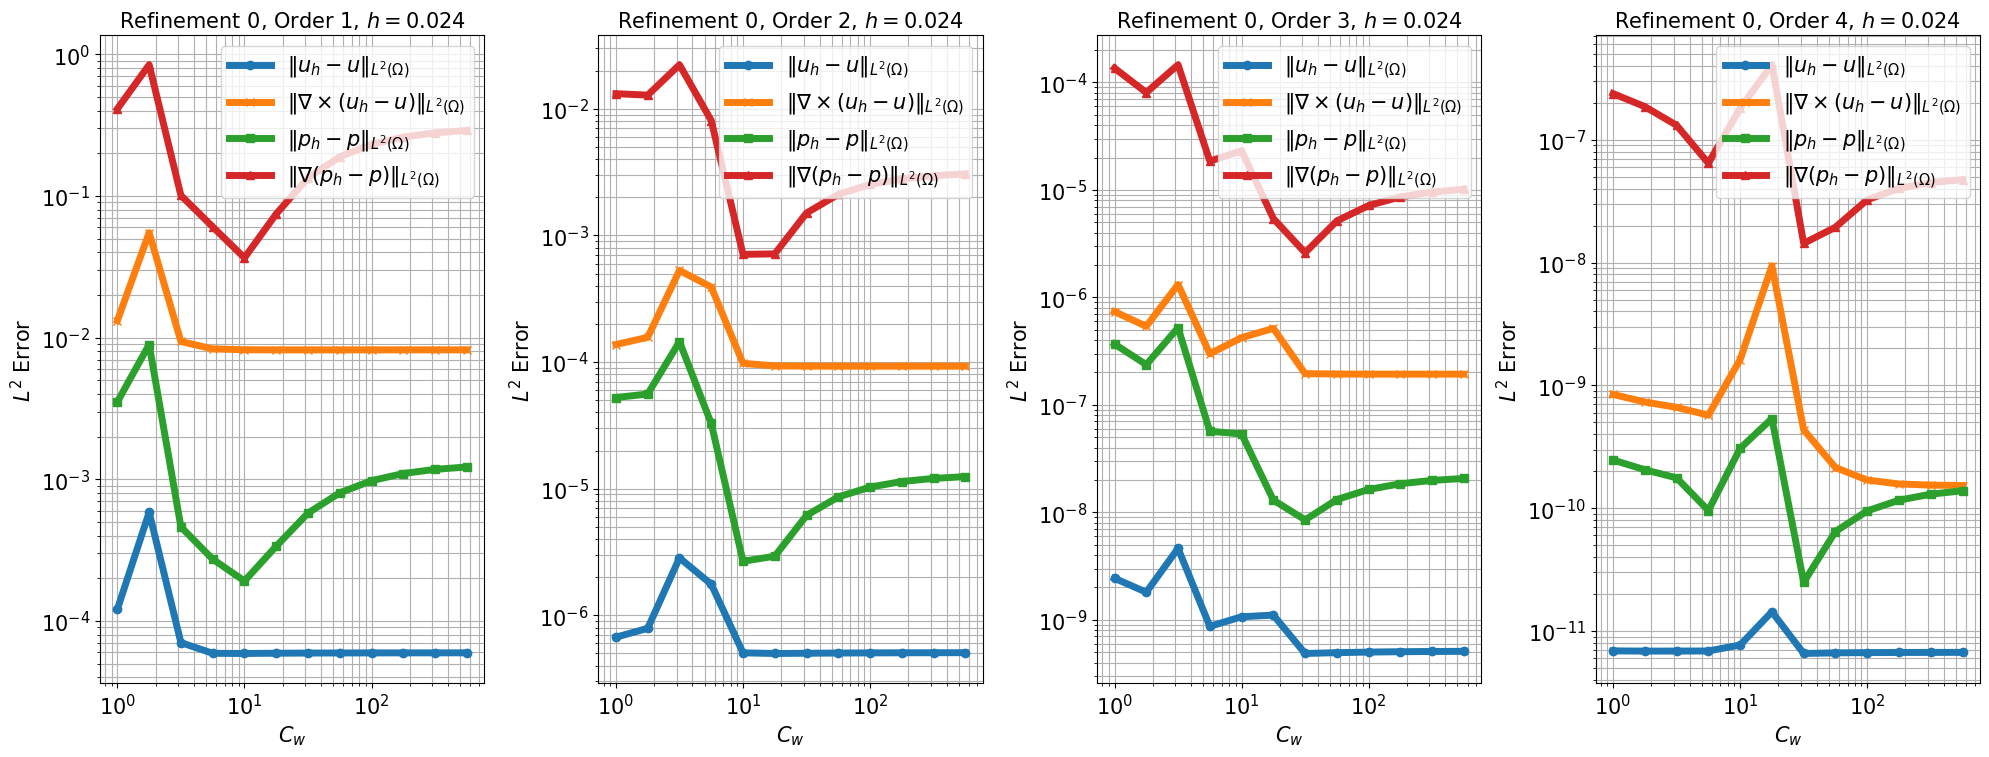

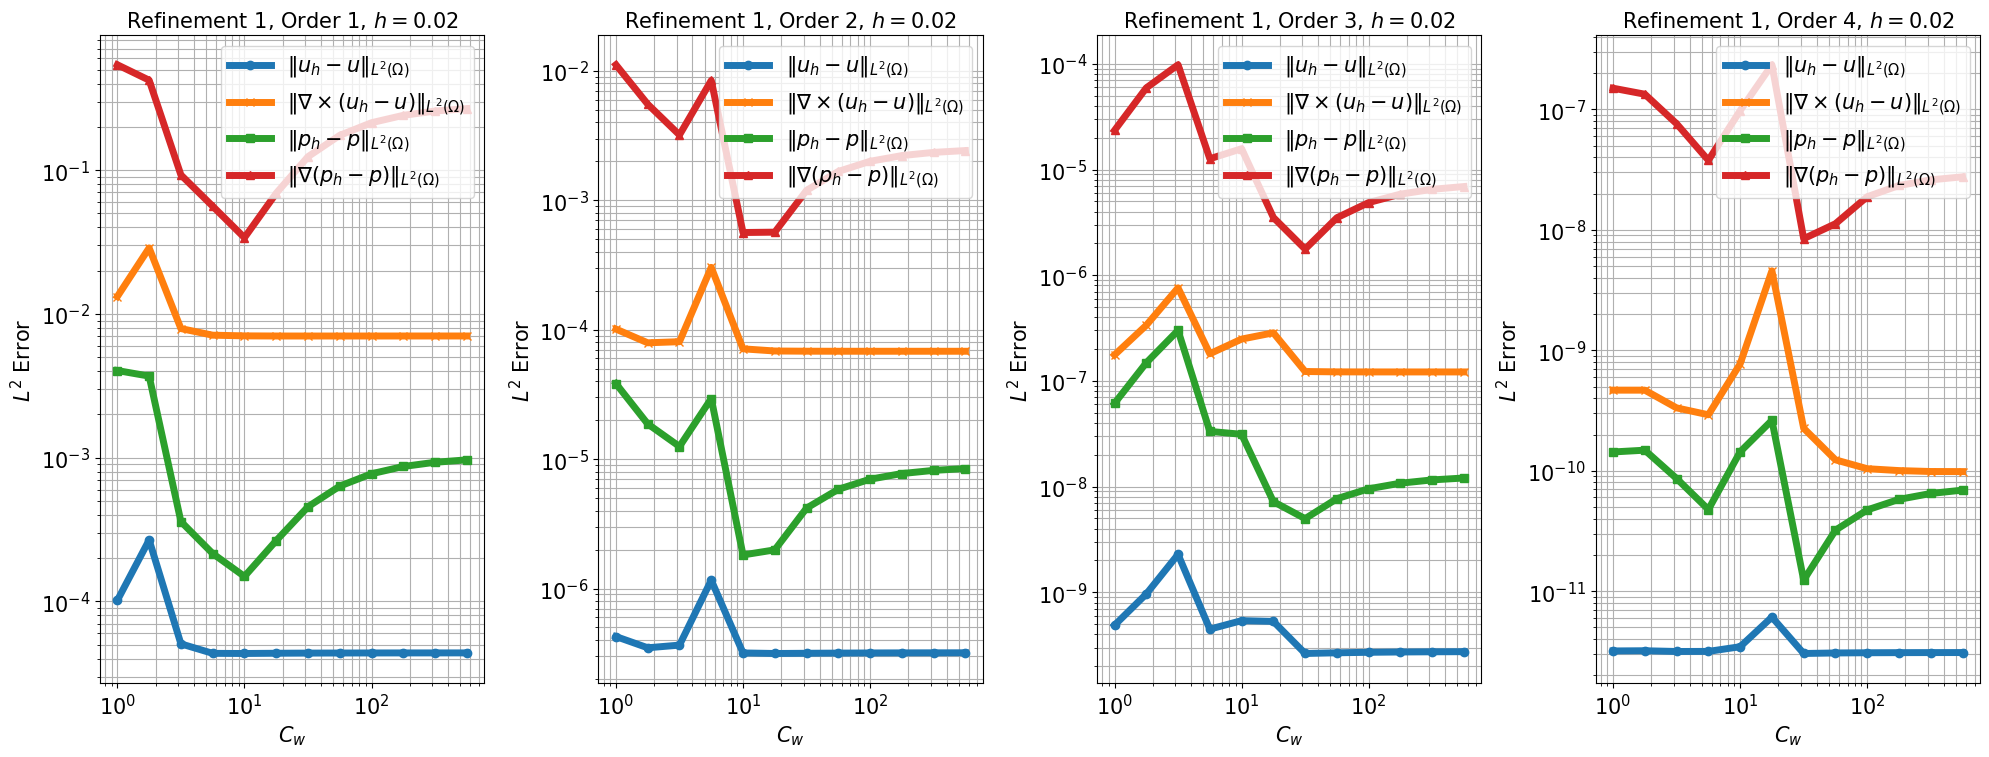

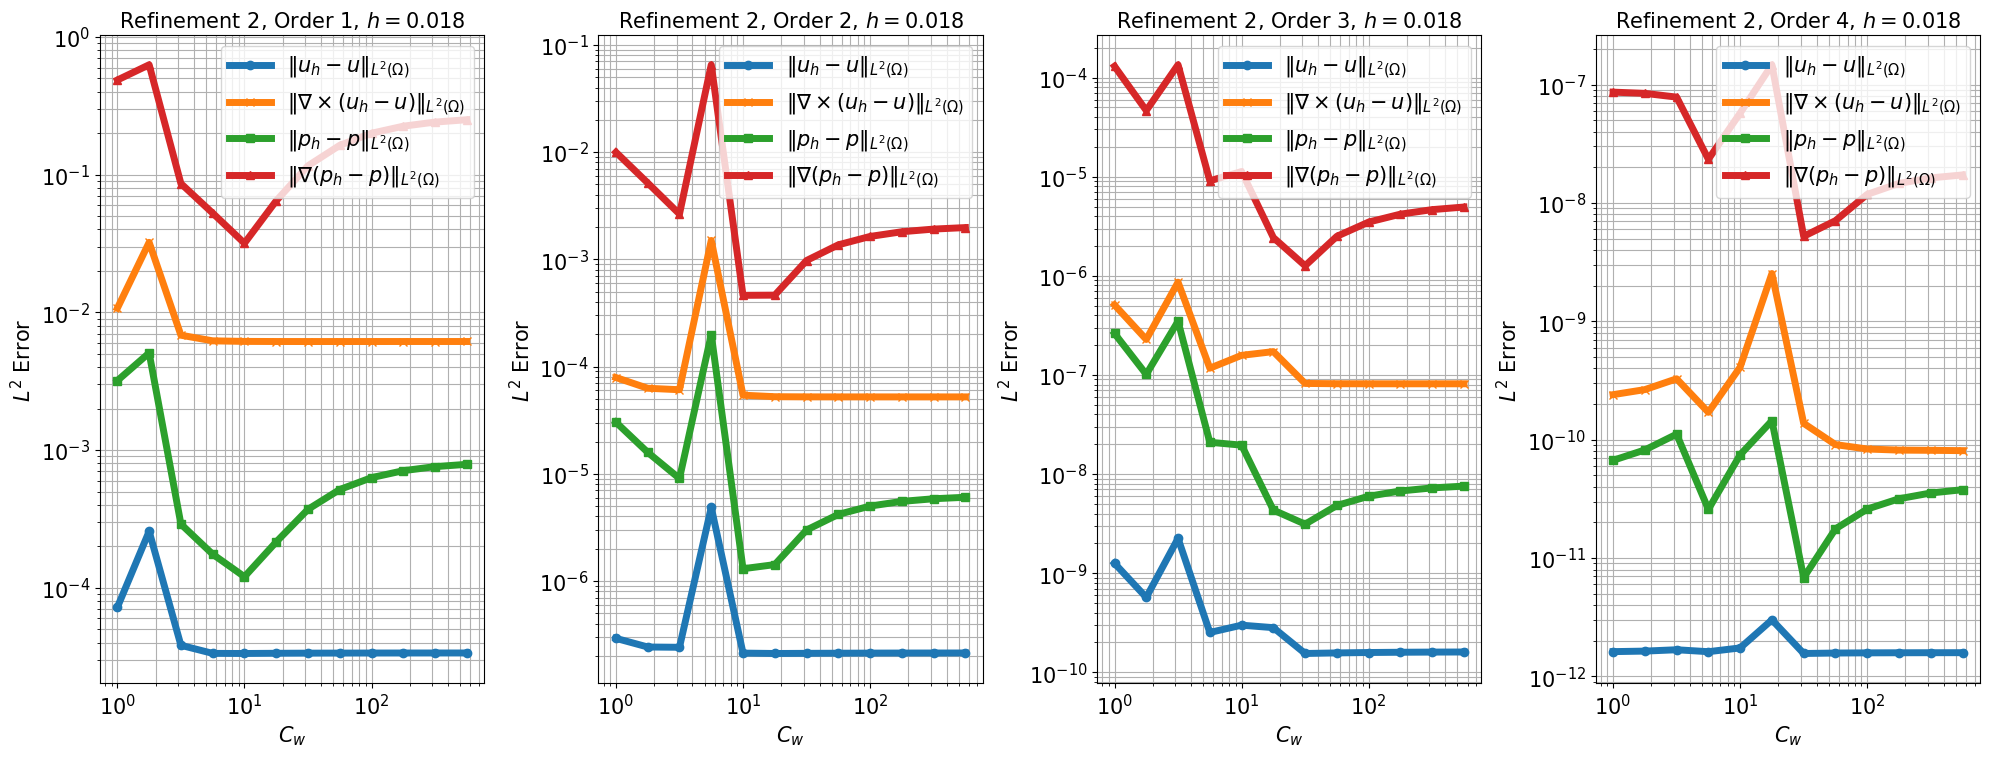

In [43]:
# Plot c_W behavior
saveFigure1 = False
num_refinements = len(refinementVals)
num_orders = len(orders)

font_size = 15
line_width = 5

for refinement_step in range(num_refinements):

    fig, axs = plt.subplots(1, num_orders, figsize=(20, 8))
        
    if num_orders == 1:
        axs = [axs]

    for i, order in enumerate(orders):
        ax = axs[i]
        df = results_cw_2D[refinement_step * num_orders + i]
        
        hmax_value = round(maxh_values[refinement_step], 3)

        line_u, = ax.plot(
            df['C_w'], df['L2_error_u'],
            label=r'$\Vert u_h - u \Vert_{L^2(\Omega)}$',
            marker='o', linewidth=line_width
        )
        line_curl_u, = ax.plot(
            df['C_w'], df['L2_error_curl_u'],
            label=r'$\Vert \nabla \times (u_h - u) \Vert_{L^2(\Omega)}$',
            marker='x', linewidth=line_width
        )
        line_p, = ax.plot(
            df['C_w'], df['L2_error_p'],
            label=r'$\Vert p_h - p \Vert_{L^2(\Omega)}$',
            marker='s', linewidth=line_width
        )
        line_grad_p, = ax.plot(
            df['C_w'], df['L2_error_grad_p'],
            label=r'$\Vert \nabla (p_h - p) \Vert_{L^2(\Omega)}$',
            marker='^', linewidth=line_width
        )

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('$C_w$', fontsize=font_size)
        ax.set_ylabel('$L^2$ Error', fontsize=font_size)
        ax.set_title(f'Refinement {refinement_step}, Order {order}, $h = {hmax_value}$', fontsize=font_size)
        ax.grid(True, which='both', axis='both')
        ax.legend(fontsize=font_size, loc='upper right')

        ax.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if saveFigure1:
        fig.savefig(
            figures_dir + f'/HL_1forms_2D_Cw_refinement_{refinement_step}.pdf',
            format='pdf', bbox_inches='tight'
        )

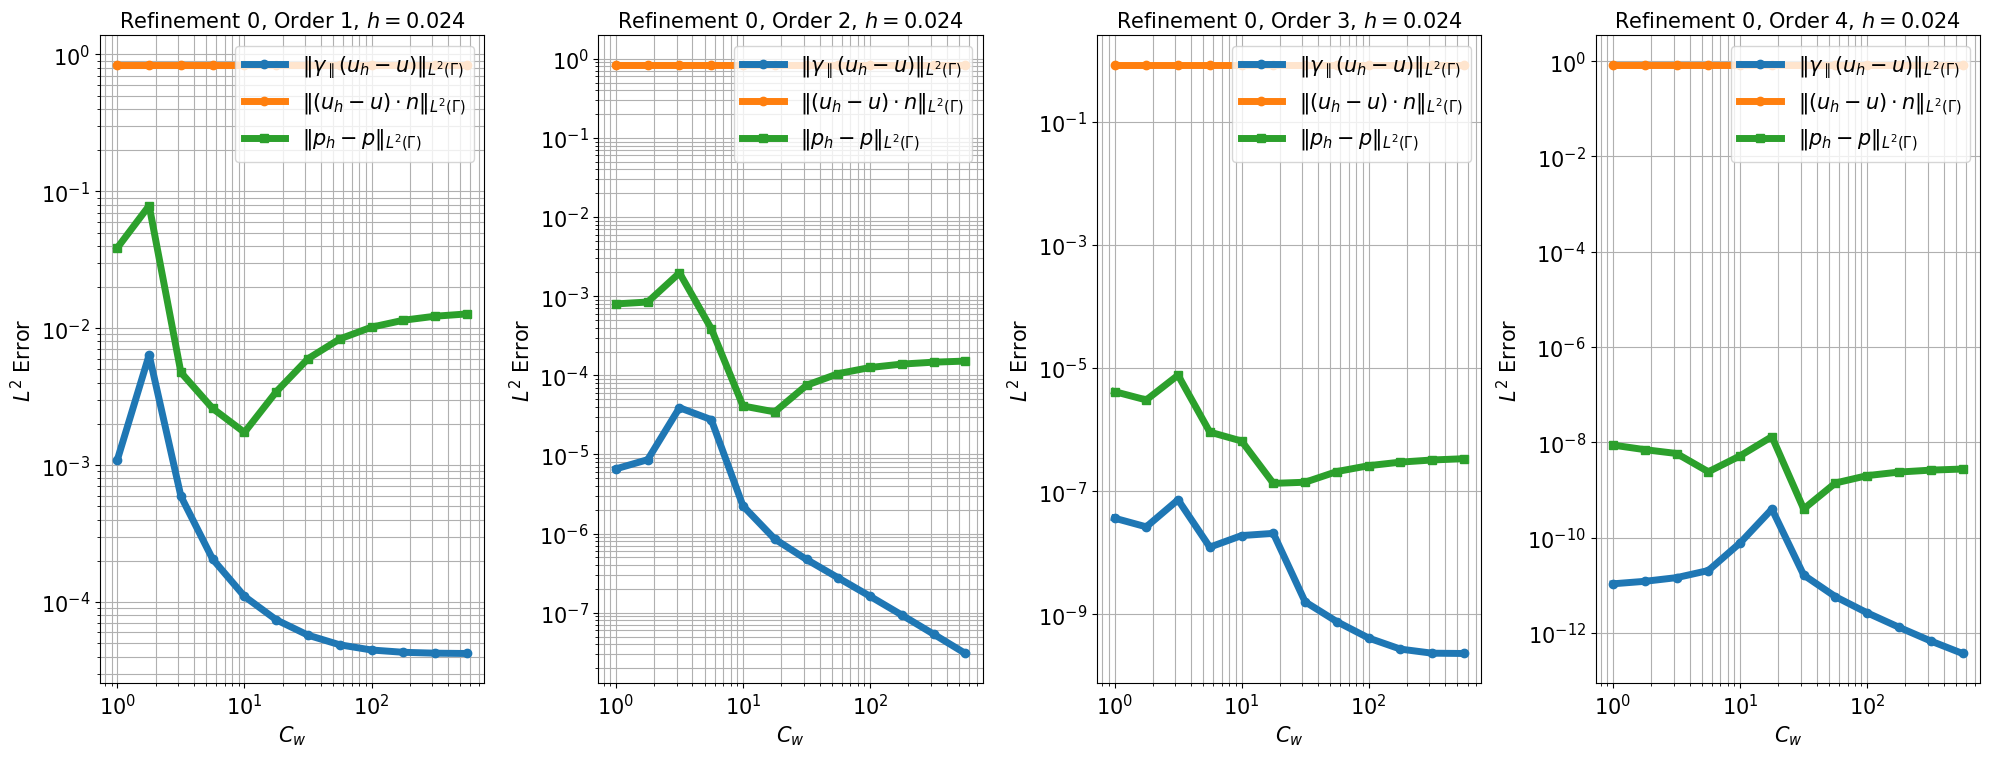

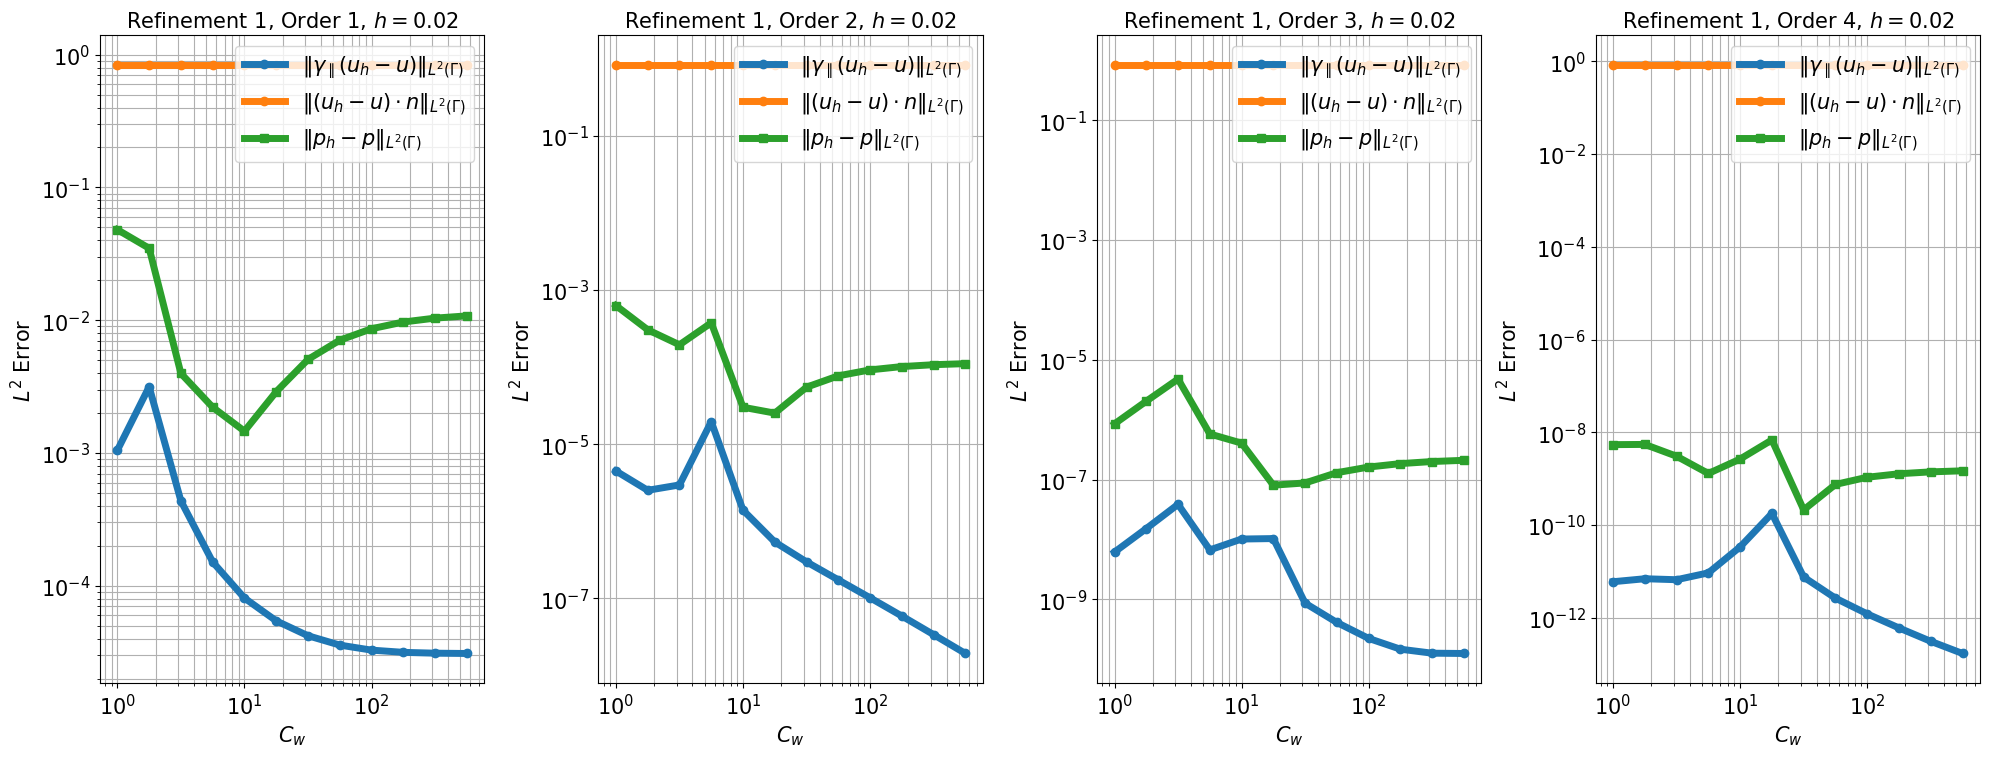

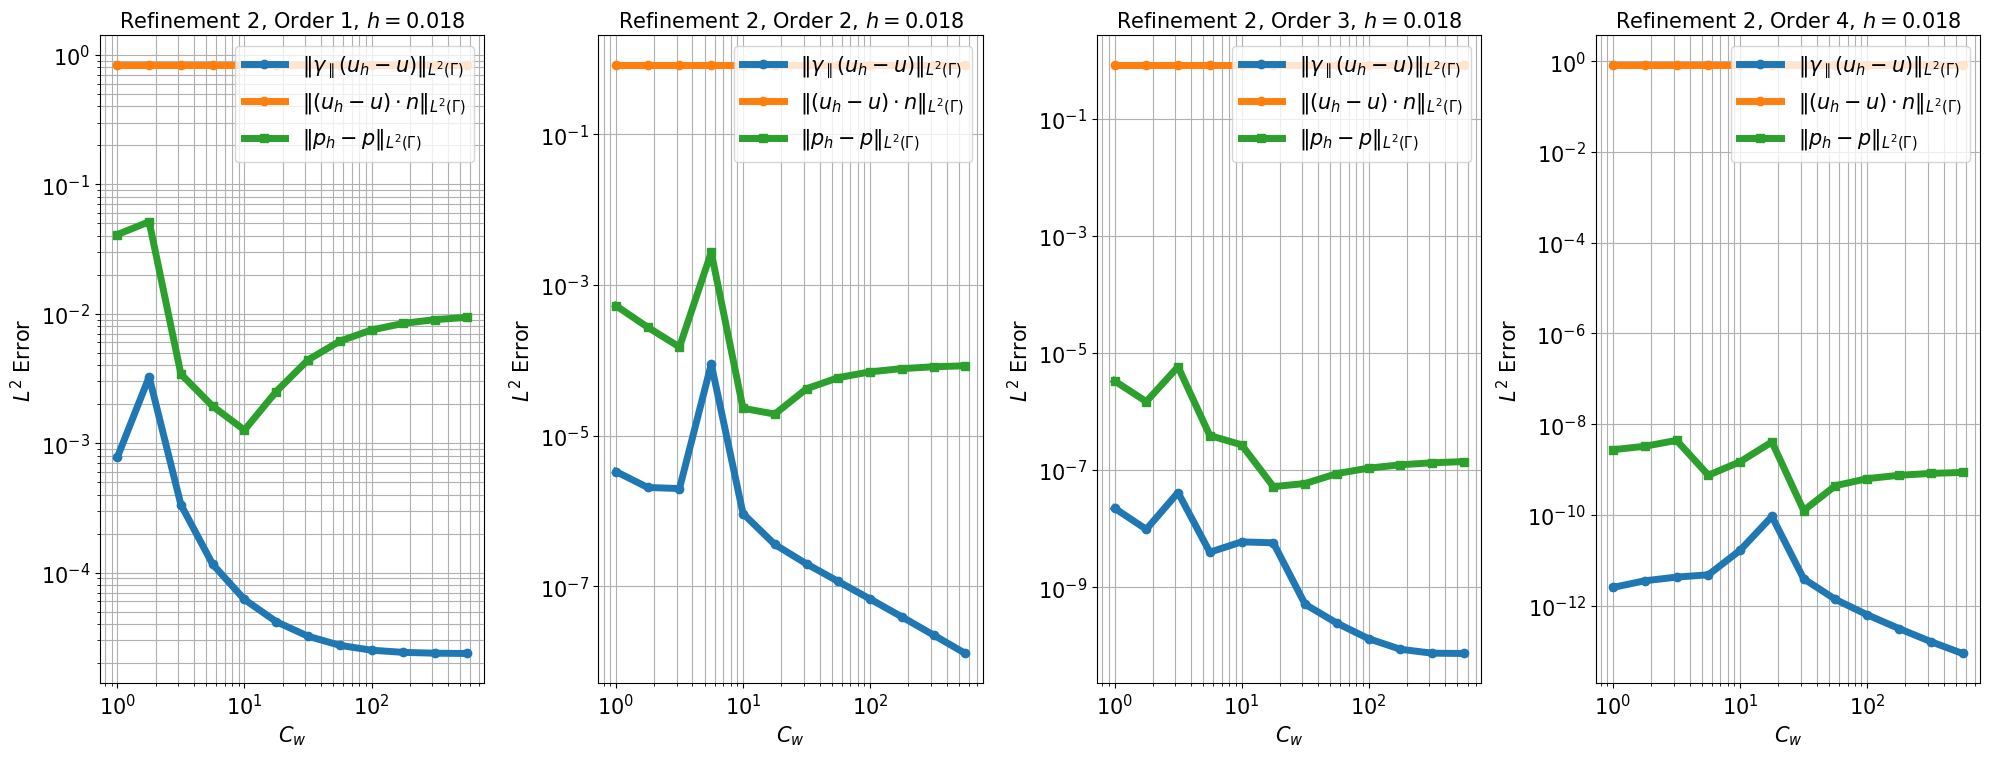

In [44]:
# Plot c_W behavior on Gamma
saveFigure2 = False
num_refinements = len(refinementVals)
num_orders = len(orders)

font_size = 15
line_width = 5

for refinement_step in range(num_refinements):

    fig, axs = plt.subplots(1, num_orders, figsize=(20, 8))
        
    if num_orders == 1:
        axs = [axs]

    for i, order in enumerate(orders):
        ax = axs[i]
        df = results_cw_2D[refinement_step * num_orders + i]
        
        hmax_value = round(maxh_values[refinement_step], 3)

        line_u_p, = ax.plot(
            df['C_w'], df['L2_error_gamma_p_u'],
            label=r'$\Vert \gamma_{\parallel}(u_h - u) \Vert_{L^2(\Gamma)}$',
            marker='o', linewidth=line_width
        )
        line_u_n, = ax.plot(
            df['C_w'], df['L2_error_u_n'],
            label=r'$\Vert (u_h - u) \cdot n \Vert_{L^2(\Gamma)}$',
            marker='o', linewidth=line_width
        )
        line_p, = ax.plot(
            df['C_w'], df['L2_error_p_Gamma'],
            label=r'$\Vert p_h - p \Vert_{L^2(\Gamma)}$',
            marker='s', linewidth=line_width
        )

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('$C_w$', fontsize=font_size)
        ax.set_ylabel('$L^2$ Error', fontsize=font_size)
        ax.set_title(f'Refinement {refinement_step}, Order {order}, $h = {hmax_value}$', fontsize=font_size)
        ax.grid(True, which='both', axis='both')
        ax.legend(fontsize=font_size, loc='upper right')

        ax.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if saveFigure2:
        fig.savefig(
            figures_dir + f'/HL_1forms_2D_Cw_Gamma_refinement_{refinement_step}.pdf',
            format='pdf', bbox_inches='tight'
        )

/home/tellocam/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


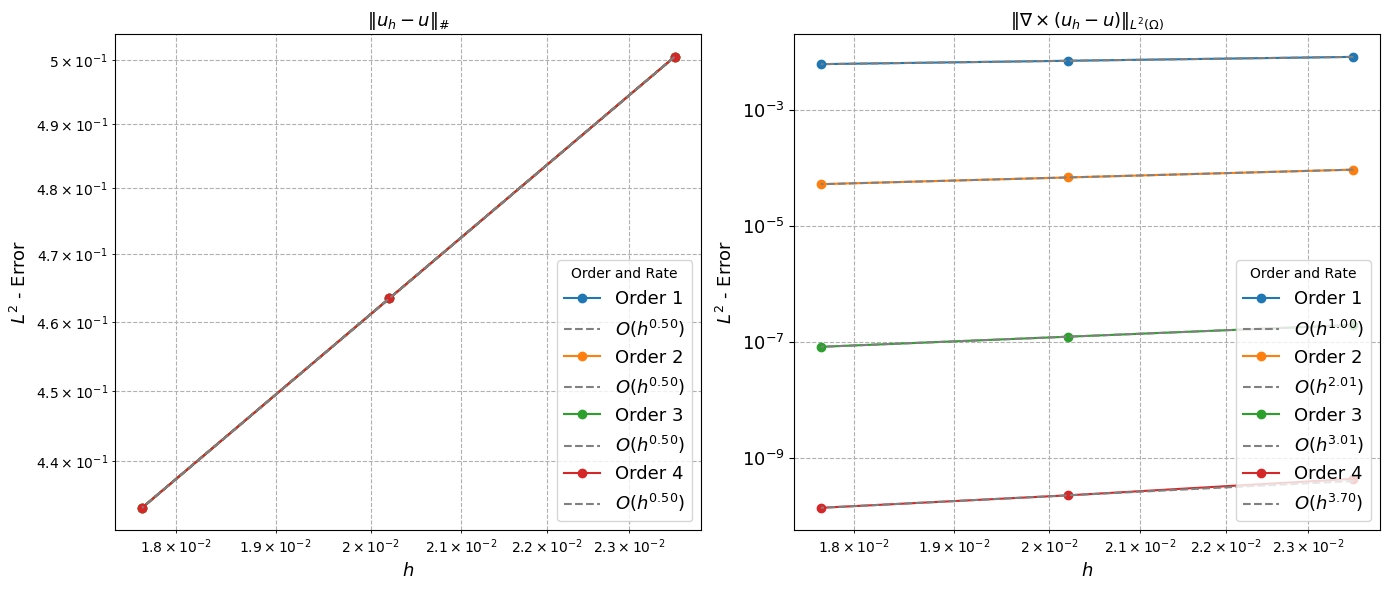

In [45]:
saveFigure2 = False
font_size = 13
df_all_results = pd.concat(results_cw_2D, ignore_index=True)
filtered_results = []

optimal_cw_per_order = {}

for order_cw in orders:
    min_error_index = df_all_results[df_all_results['order'] == order_cw]['L2_error_u'].idxmin()
    optimal_cw_per_order[order_cw] = df_all_results.loc[min_error_index, 'C_w']

for order_cw in orders:
    for hmax in maxh_values:
        group = df_all_results[
            (df_all_results['order'] == order_cw) &
            (df_all_results['hmax'] == hmax) &
            (df_all_results['C_w'] == optimal_cw_per_order[order_cw])
        ]
        
        if not group.empty:
            optimal_row = group.iloc[0]
            filtered_results.append(optimal_row)

df_filtered = pd.DataFrame(filtered_results)

# --- First figure: errors for u and curl(u) ---
error_columns_1 = ['HT_error_u', 'L2_error_curl_u']
error_titles_1  = [
    r'$\Vert u_h - u \Vert_{\#}$',
    r'$\Vert \nabla \times (u_h - u) \Vert_{L^2(\Omega)}$'
]

fig1, axs1 = plt.subplots(1, 2, figsize=(14, 6))

for i, (error_col, title) in enumerate(zip(error_columns_1, error_titles_1)):
    ax = axs1[i]

    for order_cw in orders:
        order_group = df_filtered[df_filtered['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        line, = ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')

        if len(h_values) >= 2:
            h_fit_values = h_values[-2:]
            error_fit_values = error_values[-2:]
            scaling_factor, slope = fit_reference_line(h_fit_values, error_fit_values)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color="gray",
                    label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$h$', fontsize=font_size)
    ax.set_ylabel(r'$L^2$ - Error', fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order and Rate", fontsize=font_size, loc='lower right')
    ax.tick_params(axis='both', which='major', labelsize=font_size)

plt.tight_layout()
if saveFigure2:
    fig1.savefig(figures_dir + '/HL_1forms_2D_hConvergence_optimal_Cw_per_order_u.pdf', 
                 format='pdf', bbox_inches='tight')
plt.show()

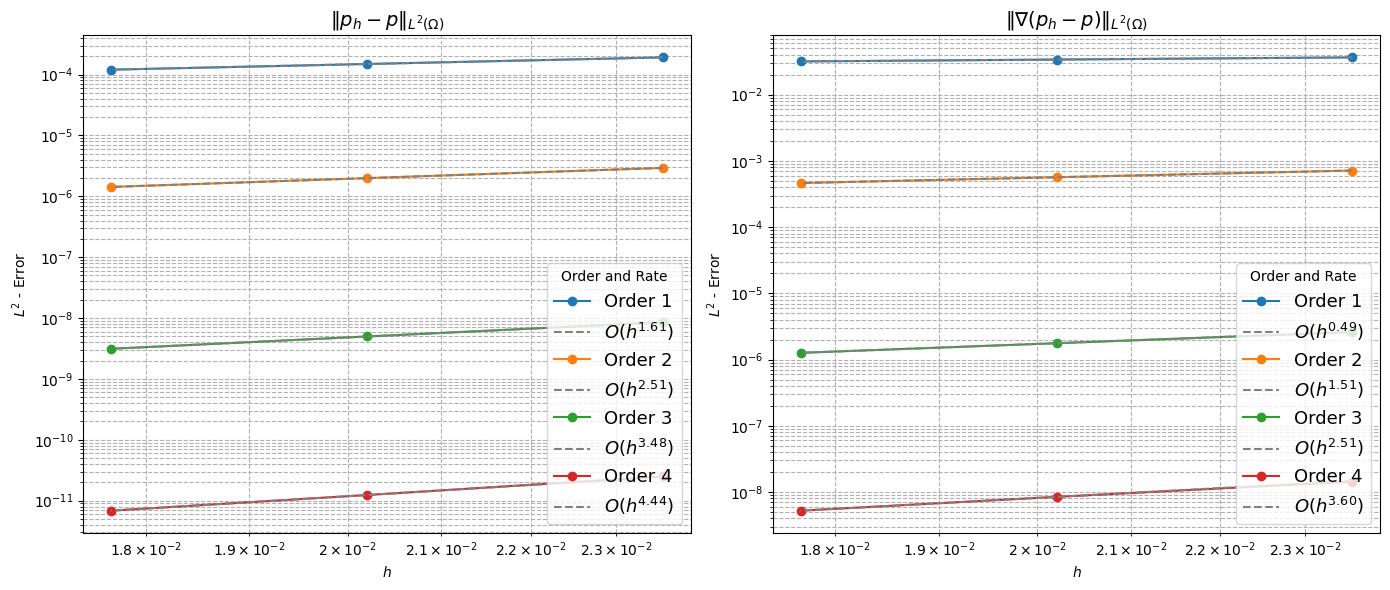

In [46]:
# errors for p and grad(p)
error_columns_2 = ['L2_error_p', 'L2_error_grad_p']
error_titles_2  = [
    r'$\Vert p_h - p \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla (p_h - p) \Vert_{L^2(\Omega)}$'
]

fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))

for i, (error_col, title) in enumerate(zip(error_columns_2, error_titles_2)):
    ax = axs2[i]

    for order_cw in orders:
        order_group = df_filtered[df_filtered['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        line, = ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')

        # Fit reference line from last two points if possible
        if len(h_values) >= 2:
            h_fit_values = h_values[-2:]
            error_fit_values = error_values[-2:]
            scaling_factor, slope = fit_reference_line(h_fit_values, error_fit_values)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color="gray",
                    label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$h$')
    ax.set_ylabel(r'$L^2$ - Error')
    ax.set_title(title, fontsize=14)
    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order and Rate", fontsize=font_size, loc='lower right')

plt.tight_layout()
if saveFigure2:
    fig2.savefig(figures_dir + '/HL_1forms_2D_hConvergence_optimal_Cw_per_order_p.pdf', 
                 format='pdf', bbox_inches='tight')
plt.show()